# Notebook associated with our manuscript on FAIR-Bio-RS

## Import required packages

In [51]:
from github import Github
import pandas as pd
import time
import os
import math
from IPython.display import clear_output
import re
import collections
%matplotlib inline
pd.set_option('display.max_colwidth', -1)

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
color_6 = '#fb5607'
color_5 = '#ef476f'
color_2 = '#ffd166'
color_3 = '#06d6a0'
color_4 = '#118ab2'
color_1 = '#073b4c'
color_palette = [color_1, color_2, color_3, color_4, color_5, color_6]

import seaborn as sns
sns.set(font='Franklin Gothic Book',
        rc={
 'axes.axisbelow': False,
 'axes.edgecolor': 'lightgrey',
 'axes.facecolor': 'None',
 'axes.grid': False,
 'axes.labelcolor': 'dimgrey',
 'axes.spines.right': False,
 'axes.spines.top': False,
 'figure.facecolor': 'white',
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'text.color': 'dimgrey',
 'xtick.bottom': False,
 'xtick.color': 'dimgrey',
 'xtick.direction': 'out',
 'xtick.top': False,
 'ytick.color': 'dimgrey',
 'ytick.direction': 'out',
 'ytick.left': False,
 'ytick.right': False})
sns.set_context("notebook", rc={"font.size":16,
                                "axes.titlesize":20,
                                "axes.labelsize":18})

## General functions

In [2]:
def create_folder_if_not_exist(folder_path):
    if not os.path.isdir(folder_path):
        os.mkdir(folder_path)
    return(folder_path)
        
def save_image_png(fig, folder_path, plot_name):
    folder_path = create_folder_if_not_exist(folder_path)
    file_name = plot_name + ".png"
    file_path = os.path.join(folder_path, file_name)
    fig.savefig(file_path, bbox_inches='tight')

def frenquency_suggestions(df_sub):
    #Frequency of suggestions
    list_suggestions = list (df_sub.values)
    list_suggestions_cleaned = []
    for item in list_suggestions:
        item = item.split(";")
        list_suggestions_cleaned.extend(item) 
    list_suggestions_cleaned = [x.strip() for x in list_suggestions_cleaned]
    frequency_all = dict(collections.Counter(list_suggestions_cleaned))
    frequency = dict( sorted(frequency_all.items(),
                               key=lambda item: item[1],
                               reverse=True))
    return(frequency)
current_folder = os.getcwd()

## Number of biomedical related repositories on GitHub

In [3]:
GITHUB_ACCESS_TOKEN = os.getenv('GITHUB_ACCESS_TOKEN')
g = Github(GITHUB_ACCESS_TOKEN)
print('Success: GitHub Access Token loaded')

Success: GitHub Access Token loaded


In [9]:
#get number of repositories on GitHub with "biomedical" included in the name, readme, or description created in a given month of a year
#since the GitHub API has a result rate limit of 1000, we search month by month assuming no single month has more than 1000 results
#we then combined monthly results to get year-wise number of repositories created with keyword biomedical
#results are saved in a dataframe and csv file for further analysis
#this code block can be skipped since the csv file with results is included with the code
def search_github_repo_created_month(keywords, created_month):
    created_month_query  = ' created:' + created_month
    query = keywords + ' in:name'+ ' in:readme' + ' in:description' + created_month_query
    result = g.search_repositories(query)
    return result

keywords = 'biomedical'
start_year = 2010
end_year = 2021
year_list = [str(x) for x in range(start_year, end_year+1)]
month_list = ["%.2d" % x for x in range(1,13)]
df = pd.DataFrame(columns = ['year', 'month', 'count'])
search_count = 0
search_limit = 30
# for year in year_list:
#     for month in month_list:
#         created_month = year + '-' + month
#         result = search_github_repo_created_month(keywords, created_month)
#         df.loc[len(df.index)] = [year, month, result.totalCount] 
#         search_count += 1
#         if search_count == search_limit:
#             time.sleep(65)
#             search_count = 0
print("Success: Month-wise number of repositories created on GitHub between " + str(start_year) + " and " + str(end_year) + " with keyword biomedical pulled and saved in a dataframe")

#get year wise results
#df_yearwise = pd.DataFrame(columns = ['year', 'count'])
# for year in year_list:
#     df_sub = df[df['year'] == year]
#     total = df_sub['count'].sum()
#     df_yearwise.loc[len(df_yearwise.index)] = [year, total] 
df_yearwise.to_csv('github_biomedical_repo_count_yearwise.csv')
print("Success: Year-wise number of repositories created on GitHub between " + str(start_year) + " and " + str(end_year) + " with keyword biomedical calculated saved in a dataframe and in a csv file")
print(df_yearwise)

Success: Month-wise number of repositories created on GitHub between 2010 and 2021 with keyword biomedical pulled and saved in a dataframe


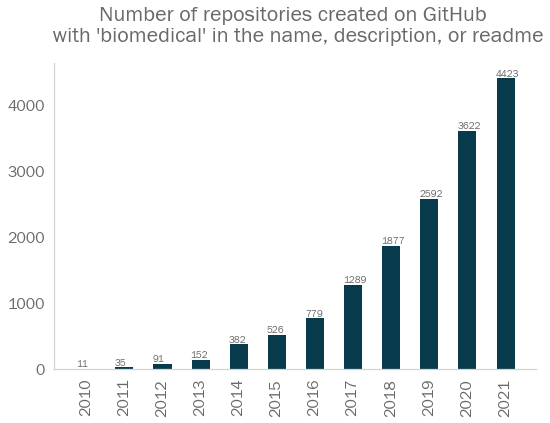

In [4]:
# visualize results
github_input_file = os.path.join('input','github_biomedical_repo_count_yearwise.csv')
df = pd.read_csv(github_input_file)
fig, ax = plt.subplots(figsize=(8,6))
width = 0.5
ind = 0
x = df['year']
y = df["count"]
bars = ax.bar(x, y, width, color=color_palette[ind])
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x(), yval + 20, round(yval,1))
ind+=1
ax.set_xticks(df['year'])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("Number of repositories created on GitHub \n with 'biomedical' in the name, description, or readme", fontsize = 22, y = 1.05)
plt.xticks(rotation=90, ha = 'center')
fig.tight_layout()
plot_name = 'github-biomedical-repo-count-yearwise'
save_image_png(fig, 'output', plot_name)

## Review analysis

In [99]:
# Load review data
# This section requires the data.xlsx file available in the docs folder at https://github.com/fairdataihub/FAIR-BioRS-data and at [ZENODO LINK]
# This assumes that the FAIR-BioRS-data folder is at the same location as the FAIR-BioRS-code folder
main_folder = os.path.dirname(os.getcwd())
data_folder = os.path.join(main_folder, 'FAIR-BioRS-data', 'docs')
data_file_name = 'data.xlsx'
data_file_location = os.path.join(data_folder, data_file_name)
df = pd.read_excel(data_file_location,
              sheet_name='literatureReviewKeywords')  

### Standards

In [70]:
#Number of studies
df_sub = df[['doiOrLink', 'standardsSuggestion']].iloc[2:].dropna()
total_studies = len(df_sub)
print("From the reviewed studies, " + str(total_studies) + " made a suggestion about the standards to follow when developing a research software")
if total_studies>0:
    display(df_sub)

From the reviewed studies, 0 made a suggestion about the standards to follow when developing a research software


In [71]:
df_sub = df[['doiOrLink', 'standardsHelp']].iloc[2:].dropna()
total_studies = len(df_sub)
print("From the reviewed studies, " + str(total_studies) + " made a suggestion about resources to help with standards")
if total_studies>0:
    display(df_sub)

From the reviewed studies, 1 made a suggestion about resources to help with standards


,doiOrLink,standardsHelp
2,https://doi.org/10.15497/RDA00065,https://fairsharing.org/standards/.


### Best practices

In [80]:
#Number of studies
df_sub = df[['doiOrLink', 'title', 'bestPracticeSuggestion']].iloc[2:].dropna()
total_studies = len(df_sub)
print("From the reviewed studies, " + str(total_studies) + " made a suggestion about the best practices to follow when developing a research software")
if total_studies>0:
    display(df_sub)

From the reviewed studies, 15 made a suggestion about the best practices to follow when developing a research software


,doiOrLink,title,bestPracticeSuggestion
9,https://arxiv.org/abs/2101.10883v4,A Fresh Look at FAIR for Research Software,Develop with a version control system
11,https://doi.org/10.12688/f1000research.11407.1,Four simple recommendations to encourage best practices in research software,"Develop with a version control system (GitHub, Bitbucket); Use container technologies (Docker)"
18,https://doi.org/10.5281/zenodo.2555498,Top 10 FAIR Data & Software Things - Research Software,Make code modular; Have code level documentation; Provide tests; Develop with a version control system
22,https://doi.org/10.1515/itit-2019-0040,From FAIR research data toward FAIR and open research software,Make code modular; Use container technologies (Docker); Develop with a version control system (GitHub)
25,https://doi.org/10.12688/f1000research.23224.2,"An Environment for Sustainable Research Software in Germany and beyond: Current State, Open Challenges, and Call for Action",Use container technologies (Docker)
30,https://doi.org/10.5281/zenodo.4310217\n,"Five recommendations for ""FAIR software""","Develop with a version control system (GitHub, Bitbucket, GitLab)"
32,https://doi.org/10.1371/journal.pone.0213013,Reproducible big data science: A case study in continuous FAIRness,"Use container technologies (Docker, Singularity)"
35,https://dx.doi.org/10.12688%2Ff1000research.10750.2,General guidelines for biomedical software development,"Develop with a version control system (GitHub, Bitbucket); Have code level documentation; Use container technologies (Docker)"
36,https://datascience.nih.gov/tools-and-analytics/best-practices-for-sharing-research-software-faq,Best Practices for Sharing Research Software,"Develop with a version control system (GitHub, Bitbucket, GitLab)"
37,https://doi.org/10.3389/fgene.2014.00199,On best practices in the development of bioinformatics software,Develop with a version control system; Provide tests; Include sample data


In [81]:
#Frequency of suggestions
df_sub2 = df_sub
list_suggestions = df_sub2['bestPracticeSuggestion']
list_suggestions_cleaned = []
for item in list_suggestions:
    item = item.split(";")
    item = [re.sub("[\(\[].*?[\)\]]", "", x) for x in item]
    item = [x.strip() for x in item]
    list_suggestions_cleaned.extend(item) 
list_suggestions_unique = list(set(list_suggestions_cleaned))
print(list_suggestions_unique)
frequency = {}
for item in list_suggestions_unique:
    print('---------------')
    print(item)
    df_sub3 = df_sub[df_sub['bestPracticeSuggestion'].str.contains(item)]
    display(df_sub3)
    frequency[item] = len(df_sub3)
frequency = dict( sorted(frequency.items(),
                               key=lambda item: item[1],
                               reverse=True))
print(frequency)

['Develop with a version control system', 'Record dependencies', 'Have code level documentation', 'Include sample data', 'Use container technologies', 'Make code modular', 'Provide tests']
---------------
Develop with a version control system


,doiOrLink,title,bestPracticeSuggestion
9,https://arxiv.org/abs/2101.10883v4,A Fresh Look at FAIR for Research Software,Develop with a version control system
11,https://doi.org/10.12688/f1000research.11407.1,Four simple recommendations to encourage best practices in research software,"Develop with a version control system (GitHub, Bitbucket); Use container technologies (Docker)"
18,https://doi.org/10.5281/zenodo.2555498,Top 10 FAIR Data & Software Things - Research Software,Make code modular; Have code level documentation; Provide tests; Develop with a version control system
22,https://doi.org/10.1515/itit-2019-0040,From FAIR research data toward FAIR and open research software,Make code modular; Use container technologies (Docker); Develop with a version control system (GitHub)
30,https://doi.org/10.5281/zenodo.4310217\n,"Five recommendations for ""FAIR software""","Develop with a version control system (GitHub, Bitbucket, GitLab)"
35,https://dx.doi.org/10.12688%2Ff1000research.10750.2,General guidelines for biomedical software development,"Develop with a version control system (GitHub, Bitbucket); Have code level documentation; Use container technologies (Docker)"
36,https://datascience.nih.gov/tools-and-analytics/best-practices-for-sharing-research-software-faq,Best Practices for Sharing Research Software,"Develop with a version control system (GitHub, Bitbucket, GitLab)"
37,https://doi.org/10.3389/fgene.2014.00199,On best practices in the development of bioinformatics software,Develop with a version control system; Provide tests; Include sample data
39,https://libguides.mit.edu/software,Citing & publishing software: Publishing research software,Develop with a version control system
40,https://coderefinery.github.io/reproducible-research/,Reproducible research,"Develop with a version control system; Record dependencies (requirement.txt); Use container technologies (Docker, Singularity); Have code level documentation"


---------------
Record dependencies


,doiOrLink,title,bestPracticeSuggestion
40,https://coderefinery.github.io/reproducible-research/,Reproducible research,"Develop with a version control system; Record dependencies (requirement.txt); Use container technologies (Docker, Singularity); Have code level documentation"
42,https://doi.org/10.1371/journal.pcbi.1005510,\nGood enough practices in scientific computing,"Develop with a version control system (GitHub, Bitbucket, GitLab); Have code level documentation; Provide tests; Record dependencies (requirement.txt, README)"


---------------
Have code level documentation


,doiOrLink,title,bestPracticeSuggestion
18,https://doi.org/10.5281/zenodo.2555498,Top 10 FAIR Data & Software Things - Research Software,Make code modular; Have code level documentation; Provide tests; Develop with a version control system
35,https://dx.doi.org/10.12688%2Ff1000research.10750.2,General guidelines for biomedical software development,"Develop with a version control system (GitHub, Bitbucket); Have code level documentation; Use container technologies (Docker)"
40,https://coderefinery.github.io/reproducible-research/,Reproducible research,"Develop with a version control system; Record dependencies (requirement.txt); Use container technologies (Docker, Singularity); Have code level documentation"
41,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6301674/,Ten simple rules for documenting scientific software,Have code level documentation
42,https://doi.org/10.1371/journal.pcbi.1005510,\nGood enough practices in scientific computing,"Develop with a version control system (GitHub, Bitbucket, GitLab); Have code level documentation; Provide tests; Record dependencies (requirement.txt, README)"


---------------
Include sample data


,doiOrLink,title,bestPracticeSuggestion
37,https://doi.org/10.3389/fgene.2014.00199,On best practices in the development of bioinformatics software,Develop with a version control system; Provide tests; Include sample data


---------------
Use container technologies


,doiOrLink,title,bestPracticeSuggestion
11,https://doi.org/10.12688/f1000research.11407.1,Four simple recommendations to encourage best practices in research software,"Develop with a version control system (GitHub, Bitbucket); Use container technologies (Docker)"
22,https://doi.org/10.1515/itit-2019-0040,From FAIR research data toward FAIR and open research software,Make code modular; Use container technologies (Docker); Develop with a version control system (GitHub)
25,https://doi.org/10.12688/f1000research.23224.2,"An Environment for Sustainable Research Software in Germany and beyond: Current State, Open Challenges, and Call for Action",Use container technologies (Docker)
32,https://doi.org/10.1371/journal.pone.0213013,Reproducible big data science: A case study in continuous FAIRness,"Use container technologies (Docker, Singularity)"
35,https://dx.doi.org/10.12688%2Ff1000research.10750.2,General guidelines for biomedical software development,"Develop with a version control system (GitHub, Bitbucket); Have code level documentation; Use container technologies (Docker)"
40,https://coderefinery.github.io/reproducible-research/,Reproducible research,"Develop with a version control system; Record dependencies (requirement.txt); Use container technologies (Docker, Singularity); Have code level documentation"


---------------
Make code modular


,doiOrLink,title,bestPracticeSuggestion
18,https://doi.org/10.5281/zenodo.2555498,Top 10 FAIR Data & Software Things - Research Software,Make code modular; Have code level documentation; Provide tests; Develop with a version control system
22,https://doi.org/10.1515/itit-2019-0040,From FAIR research data toward FAIR and open research software,Make code modular; Use container technologies (Docker); Develop with a version control system (GitHub)


---------------
Provide tests


,doiOrLink,title,bestPracticeSuggestion
18,https://doi.org/10.5281/zenodo.2555498,Top 10 FAIR Data & Software Things - Research Software,Make code modular; Have code level documentation; Provide tests; Develop with a version control system
37,https://doi.org/10.3389/fgene.2014.00199,On best practices in the development of bioinformatics software,Develop with a version control system; Provide tests; Include sample data
42,https://doi.org/10.1371/journal.pcbi.1005510,\nGood enough practices in scientific computing,"Develop with a version control system (GitHub, Bitbucket, GitLab); Have code level documentation; Provide tests; Record dependencies (requirement.txt, README)"


{'Develop with a version control system': 12, 'Use container technologies': 6, 'Have code level documentation': 5, 'Provide tests': 3, 'Record dependencies': 2, 'Make code modular': 2, 'Include sample data': 1}


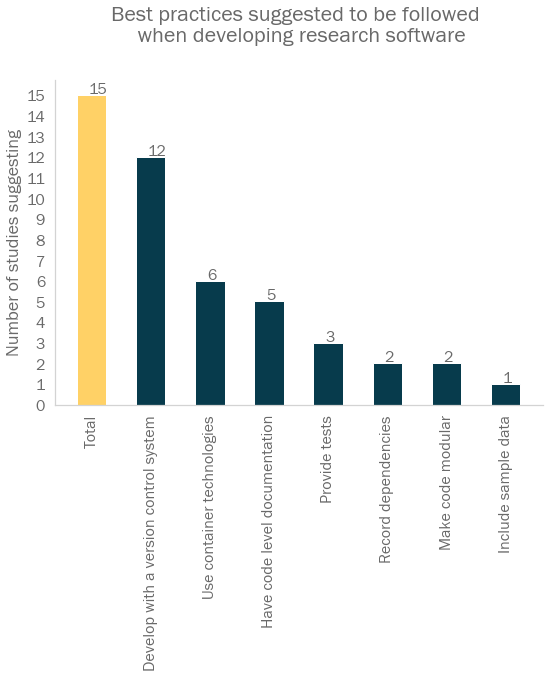

In [88]:
# Visualize
fig, ax = plt.subplots(figsize=(8,10))
width = 0.5
ind = 0
x = list(frequency.keys())
y = list(frequency.values())

# total
bars = ax.bar("Total", total_studies, width, color=color_palette[1])
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x()+0.2, yval + 0.1, round(yval,1))
bars = (ax.bar(x, y, width, color=color_palette[ind]))
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x()+0.2, yval + 0.1, round(yval,1))
ind+=1
ax.set_xticks(["Total"] + x)
ax.set_yticks(range(0, total_studies+1))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel('Number of studies suggesting', fontsize=18)
plt.title("Best practices suggested to be followed \n when developing research software", fontsize = 22, y = 1.1)
plt.xticks(rotation = 90, ha = 'center')
fig.tight_layout()
plot_name = 'files-suggested'
save_image_png(fig, 'output', plot_name)

In [89]:
#Number of studies
df_sub = df[['doiOrLink', 'title', 'bestPracticeHelp']].iloc[2:].dropna()
total_studies = len(df_sub)
print("From the reviewed studies, " + str(total_studies) + " made a suggestion about resources to help with best practices")
if total_studies>0:
    display(df_sub)

From the reviewed studies, 3 made a suggestion about resources to help with best practices


,doiOrLink,title,bestPracticeHelp
18,https://doi.org/10.5281/zenodo.2555498,Top 10 FAIR Data & Software Things - Research Software,https://guide.esciencecenter.nl/#/; https://journals.plos.org/plosbiology/article?id=10.1371/journal.pbio.1001745; https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1005510
30,https://doi.org/10.5281/zenodo.4310217\n,"Five recommendations for ""FAIR software""",https://software.ac.uk/choosing-repository-your-software-project
40,https://coderefinery.github.io/reproducible-research/,Reproducible research,https://coderefinery.github.io/reproducible-research/dependencies/\n\nhttps://coderefinery.github.io/reproducible-research/organizing-projects/ \n\nhttps://coderefinery.github.io/reproducible-research/environments/


### Best practices for documentation

In [95]:
df_sub = df[['doiOrLink', 'title', 'documentationSuggestion']].iloc[2:].dropna()
total_studies = len(df_sub)
print("From the reviewed studies, " + str(total_studies) + " made a suggestion about documenting a research software")
if total_studies>0:
    display(df_sub)

From the reviewed studies, 6 made a suggestion about documenting a research software


,doiOrLink,title,documentationSuggestion
11,https://doi.org/10.12688/f1000research.11407.1,Four simple recommendations to encourage best practices in research software,README; GitHub pages; ReadTheDoc
24,https://hal.archives-ouvertes.fr/hal-02475835,Curated Archiving of Research Software Artifacts: lessons learned from the French open archive,README
30,https://doi.org/10.5281/zenodo.4310217\n,"Five recommendations for ""FAIR software""",README
40,https://coderefinery.github.io/reproducible-research/,Reproducible research,README
41,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6301674/,Ten simple rules for documenting scientific software,README
42,https://doi.org/10.1371/journal.pcbi.1005510,\nGood enough practices in scientific computing,README


In [96]:
df_sub = df[['doiOrLink', 'title', 'documentationHelp']].iloc[2:].dropna()
total_studies = len(df_sub)
print("From the reviewed studies, " + str(total_studies) + " made a suggestion about resources to help with documenting a research software")
if total_studies>0:
    display(df_sub)

From the reviewed studies, 6 made a suggestion about resources to help with documenting a research software


,doiOrLink,title,documentationHelp
18,https://doi.org/10.5281/zenodo.2555498,Top 10 FAIR Data & Software Things - Research Software,Write the Docs page explains and gives examples of good documentation: https://www.writethedocs.org/guide/writing/beginners-guide-to-docs/
25,https://doi.org/10.12688/f1000research.23224.2,"An Environment for Sustainable Research Software in Germany and beyond: Current State, Open Challenges, and Call for Action",Doxygen
35,https://dx.doi.org/10.12688%2Ff1000research.10750.2,General guidelines for biomedical software development,Sphinx3; Javadoc
36,https://datascience.nih.gov/tools-and-analytics/best-practices-for-sharing-research-software-faq,Best Practices for Sharing Research Software,https://bssw.io/items?topic=documentation
41,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6301674/,Ten simple rules for documenting scientific software,Sphinx; perldoc; Javadoc; Roxygen
46,https://doi.org/10.15497/rda00052,RDA COVID-19 Recommendations and Guidelines on Data Sharing,Ten simple rules for documenting scientific software


### Files suggested to be shared

In [100]:
#Number of studies
df_sub = df[['doiOrLink', 'title', 'dataFileSuggestion']].iloc[2:].dropna()
total_studies = len(df_sub)
print("From the reviewed studies, " + str(total_studies) + " made a suggestion about the files to be shared for a research software")
display(df_sub)

From the reviewed studies, 6 made a suggestion about the files to be shared for a research software


,doiOrLink,title,dataFileSuggestion
3,https://doi.org/10.1016/j.patter.2021.100222,Taking a fresh look at FAIR for research software,Source code; Executable
9,https://arxiv.org/abs/2101.10883v4,A Fresh Look at FAIR for Research Software,Source code
19,https://doi.org/10.3389/fninf.2017.00069,"Re-run, repeat, reproduce, reuse, replicate: Transforming code into scientific contributions",Source code; Input data; Result data
32,https://doi.org/10.1371/journal.pone.0213013,Reproducible big data science: A case study in continuous FAIRness,Source code
36,https://datascience.nih.gov/tools-and-analytics/best-practices-for-sharing-research-software-faq,Best Practices for Sharing Research Software,Source code; Executable
37,https://doi.org/10.3389/fgene.2014.00199,On best practices in the development of bioinformatics software,Source code


In [103]:
#Frequency of suggestions
frequency = frenquency_suggestions(df_sub['dataFileSuggestion'])
print(frequency)

{'Source code': 6, 'Executable': 2, 'Input data': 1, 'Result data': 1}


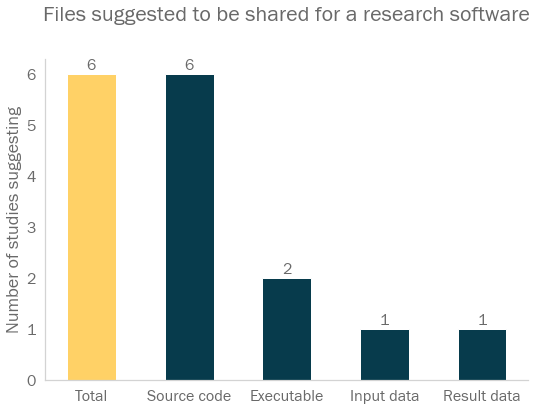

In [104]:
# Visualize
fig, ax = plt.subplots(figsize=(8,6))
width = 0.5
ind = 0
x = list(frequency.keys())
y = list(frequency.values())

# total
bars = ax.bar("Total", total_studies, width, color=color_palette[1])
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x()+0.2, yval + 0.1, round(yval,1))
bars = (ax.bar(x, y, width, color=color_palette[ind]))
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x()+0.2, yval + 0.1, round(yval,1))
ind+=1
ax.set_xticks(["Total"] + x)
ax.set_yticks(range(0, max(y)+1))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel('Number of studies suggesting', fontsize=18)
plt.title("Files suggested to be shared for a research software", fontsize = 22, y = 1.1)
plt.xticks(ha = 'center')
fig.tight_layout()
plot_name = 'files-suggested'
save_image_png(fig, 'output', plot_name)

### Metadata files suggested to be included

In [105]:
#Number of studies
df_sub = df['metadataFilesSuggestion'].iloc[2:].dropna()
total_studies = len(df_sub)
print("From the reviewed studies, " + str(total_studies) + " made a suggestion about the metadata files and ontologies to be used for a research software")
print(df_sub)

From the reviewed studies, 15 made a suggestion about the metadata files and ontologies to be used for a research software
2     CodeMeta                                                                                                                                                                                      
4     biotoolsSchema; CodeMeta; Bioschemas Tool profile; R packages DESCRIPTION file; PEP 566 Metadata for Python Software Packages; Software Ontology; EDAM; OntoSoft; PROV-O; RDA Research Schemas
5     CodeMeta                                                                                                                                                                                      
9     CodeMeta                                                                                                                                                                                      
10    CodeMeta                                                                           

In [107]:
#Frequency of suggestions
frequency = frenquency_suggestions(df_sub)
print(frequency)

{'CodeMeta': 11, 'Citation File Format': 6, 'EDAM': 2, 'A CITATION file': 2, 'biotoolsSchema': 1, 'Bioschemas Tool profile': 1, 'R packages DESCRIPTION file': 1, 'PEP 566 Metadata for Python Software Packages': 1, 'Software Ontology': 1, 'OntoSoft': 1, 'PROV-O': 1, 'RDA Research Schemas': 1}


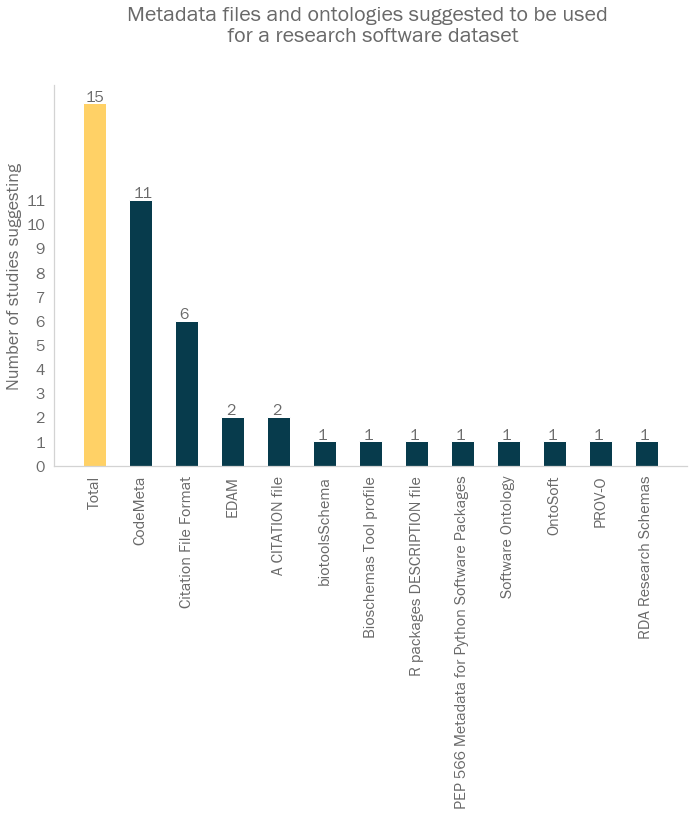

In [108]:
# Visualize
fig, ax = plt.subplots(figsize=(10,12))
width = 0.5
ind = 0
x = list(frequency.keys())
y = list(frequency.values())

# total
bars = ax.bar("Total", total_studies, width, color=color_palette[1])
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x()+0.05, yval + 0.1, round(yval,1))
bars = (ax.bar(x, y, width, color=color_palette[ind]))
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x()+0.1, yval + 0.1, round(yval,1))
ind+=1
ax.set_xticks(["Total"] + x)
ax.set_yticks(range(0, max(y)+1))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel('Number of studies suggesting', fontsize=18)
plt.title("Metadata files and ontologies suggested to be used \n for a research software dataset", fontsize = 22, y = 1.1)
plt.xticks(rotation=90, ha = 'center')
fig.tight_layout()
plot_name = 'metadata-files-suggested'
save_image_png(fig, 'output', plot_name)

### License suggested to be used

In [296]:
#Number of studies
df_sub = df['licenseSuggestion'].iloc[2:].dropna()
total_studies = len(df_sub)
print("From the reviewed studies, " + str(total_studies) + " made a suggestion about the licenses to be used for sharing a research software")
print(df_sub)

From the reviewed studies, 13 made a suggestion about the licenses to be used for sharing a research software
2                                  Open source licenses
4             Open source licenses; Permissive licenses
10                                 Open source licenses
11                                OSI-approved licenses
22                                 Open source licenses
24           Licenses from the SPDX referential catalog
25    FSF-approved licenses; OSI-approved licenses; ...
28                                 Open source licenses
30                                      Apache 2.0; MIT
36                                OSI-approved licenses
37                                 Open source licenses
42                                  Permissive licenses
46                                 Open source licenses
Name: licenseSuggestion, dtype: object


In [297]:
#Frequency of suggestions
frequency = frenquency_suggestions(df_sub)
print(frequency)

{'Open source licenses': 7, 'OSI-approved licenses': 3, 'Permissive licenses': 2, 'Apache 2.0': 2, 'MIT': 2, 'Licenses from the SPDX referential catalog': 1, 'FSF-approved licenses': 1}


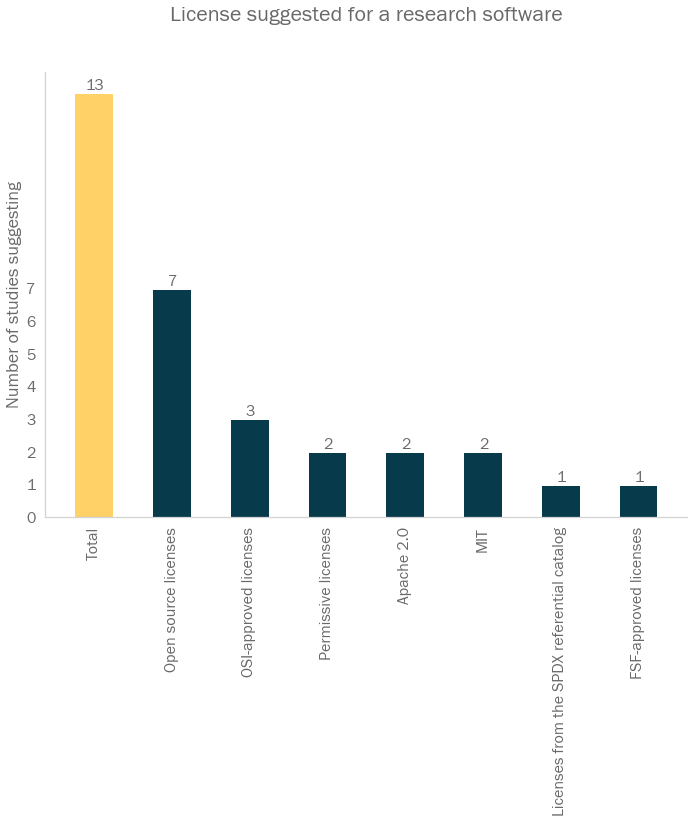

In [298]:
# Visualize
fig, ax = plt.subplots(figsize=(10,12))
width = 0.5
ind = 0
x = list(frequency.keys())
y = list(frequency.values())

# total
bars = ax.bar("Total", total_studies, width, color=color_palette[1])
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x()+0.15, yval + 0.1, round(yval,1))
bars = (ax.bar(x, y, width, color=color_palette[ind]))
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x()+0.2, yval + 0.1, round(yval,1))
ind+=1
ax.set_xticks(["Total"] + x)
ax.set_yticks(range(0, max(y)+1))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel('Number of studies suggesting', fontsize=18)
plt.title("License suggested for a research software", fontsize = 22, y = 1.1)
plt.xticks(rotation=90, ha = 'center')
fig.tight_layout()
plot_name = 'license-suggested'
save_image_png(fig, 'output', plot_name)

### Repositories suggested to be used

In [299]:
#Number of studies
df_sub = df['repositorySuggestion'].iloc[2:].dropna()
total_studies = len(df_sub)
print("From the reviewed studies, " + str(total_studies) + " made a suggestion about the repositories to use for sharing a research software")
print(df_sub)

From the reviewed studies, 18 made a suggestion about the repositories to use for sharing a research software
4     Zenodo; Software Heritage; CRAN; PyPI; Figshare
5                      Zenodo; HAL; Software Heritage
9                           Zenodo; Software Heritage
10                     Software Heritage; HAL; Zenodo
12                                   Figshare; Zenodo
15                          Zenodo; Software Heritage
18              Zenodo; Software Heritage; PyPI; CRAN
19                          Figshare; Zenodo; ModelDB
22                          Zenodo; Software Heritage
25              Zenodo; Figshare; Mendeley Data; CRAN
30                Zenodo; Figshare; Software Heritage
36                                             Zenodo
37                                           Figshare
39         CRAN; NanoHub; Dataverse; Zenodo; Figshare
40                                             Zenodo
42                                   Figshare; Zenodo
44           Zenodo; Figsh

In [300]:
#Frequency of suggestions
frequency = frenquency_suggestions(df_sub)
print(frequency)

{'Zenodo': 17, 'Figshare': 10, 'Software Heritage': 9, 'CRAN': 4, 'HAL': 3, 'PyPI': 2, 'ModelDB': 1, 'Mendeley Data': 1, 'NanoHub': 1, 'Dataverse': 1}


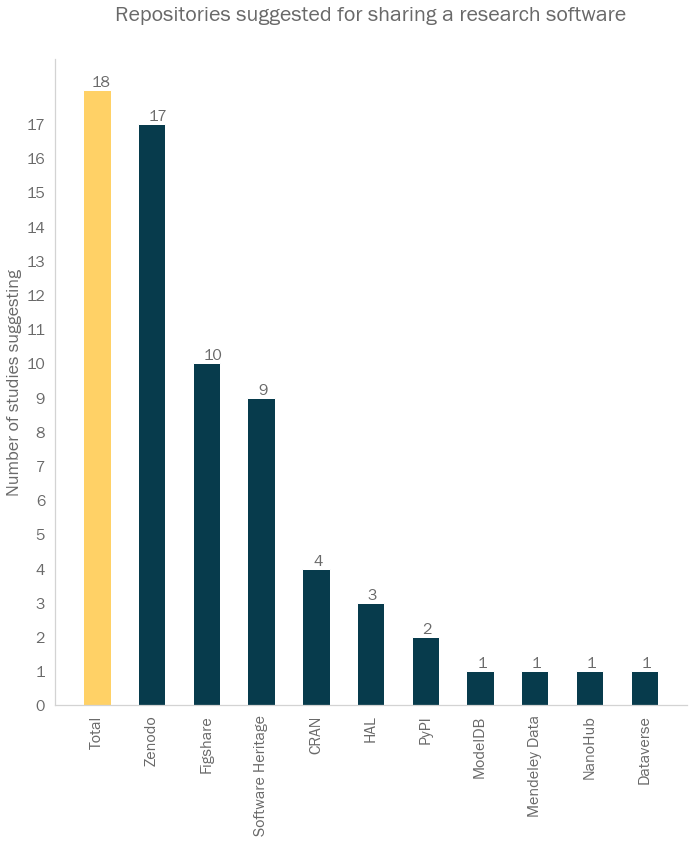

In [301]:
# Visualize
fig, ax = plt.subplots(figsize=(10,12))
width = 0.5
ind = 0
x = list(frequency.keys())
y = list(frequency.values())

# total
bars = ax.bar("Total", total_studies, width, color=color_palette[1])
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x()+0.15, yval + 0.1, round(yval,1))
bars = (ax.bar(x, y, width, color=color_palette[ind]))
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x()+0.2, yval + 0.1, round(yval,1))
ind+=1
ax.set_xticks(["Total"] + x)
ax.set_yticks(range(0, max(y)+1))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel('Number of studies suggesting', fontsize=18)
plt.title("Repositories suggested for sharing a research software", fontsize = 22, y = 1.05)
plt.xticks(rotation=90, ha = 'center')
fig.tight_layout()
plot_name = 'repositories-suggested'
save_image_png(fig, 'output', plot_name)

### Registeries suggested to be used

In [302]:
#Number of studies
df_sub = df['registerySuggestion'].iloc[2:].dropna()
total_studies = len(df_sub)
print("From the reviewed studies, " + str(total_studies) + " made a suggestion about the registeries to use for a research software")
print(df_sub)

From the reviewed studies, 7 made a suggestion about the registeries to use for a research software
4     Zenodo; Software Heritage; CRAN; PyPI; Figshar...
5            Zenodo; HAL; Software Heritage; CRAN; PyPI
9                                                Zenodo
11            bio.tools; biojs.io; Omic Tools; DataCite
18    bio.tools; Research Software Directory; rOpenS...
25                                                 CRAN
36                       Conda; Bioconductor; Dockstore
Name: registerySuggestion, dtype: object


In [303]:
#Frequency of suggestions
frequency = frenquency_suggestions(df_sub)
print(frequency)

{'Zenodo': 4, 'CRAN': 3, 'bio.tools': 3, 'Software Heritage': 2, 'PyPI': 2, 'Conda': 2, 'Figshare': 1, 'BioConductor': 1, 'BioContainers': 1, 'ASCL': 1, 'swMath': 1, 'CLARIN': 1, 'FAIRsharing': 1, 'HAL': 1, 'biojs.io': 1, 'Omic Tools': 1, 'DataCite': 1, 'Research Software Directory': 1, 'rOpenSci Project': 1, 'Bioconductor': 1, 'Dockstore': 1}


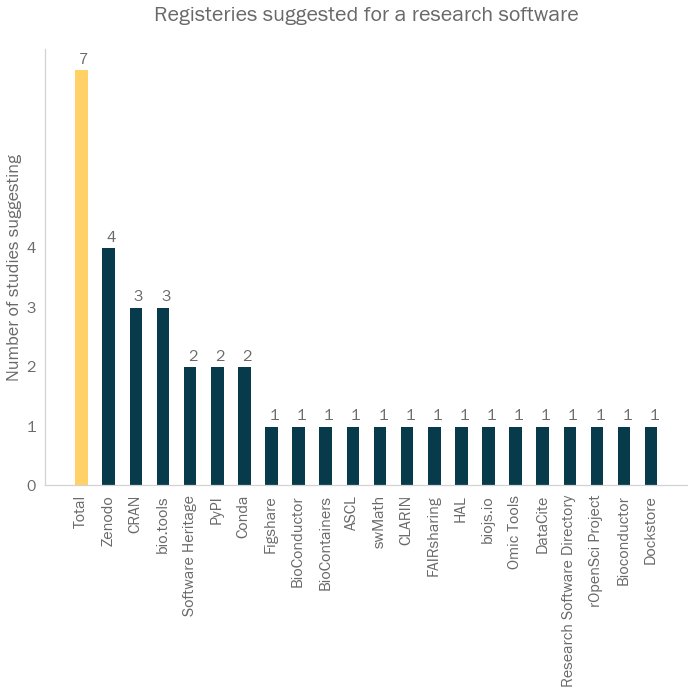

In [304]:
# Visualize
fig, ax = plt.subplots(figsize=(10,10))
width = 0.5
ind = 0
x = list(frequency.keys())
y = list(frequency.values())

# total
bars = ax.bar("Total", total_studies, width, color=color_palette[1])
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x()+0.15, yval + 0.1, round(yval,1))
bars = (ax.bar(x, y, width, color=color_palette[ind]))
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x()+0.2, yval + 0.1, round(yval,1))
ind+=1
ax.set_xticks(["Total"] + x)
ax.set_yticks(range(0, max(y)+1))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel('Number of studies suggesting', fontsize=18)
plt.title("Registeries suggested for a research software", fontsize = 22, y = 1.05)
plt.xticks(rotation=90, ha = 'center')
fig.tight_layout()
plot_name = 'registeries-suggested'
save_image_png(fig, 'output', plot_name)